## Sentiment analysis

In [ ]:
!pip install pyreadr 

In [ ]:
!pip install transformers

In [ ]:
%%capture

import sys
from transformers import pipeline
import pyreadr
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import stats

import matplotlib.dates as mdates

In [ ]:
sentiment_classifier = pipeline(task="sentiment-analysis", device=0) # run on GPU!!

In [ ]:
#pretrained_LM_path = "kornosk/bert-political-election2020-twitter-mlm" # Knowledge Enhance Masked Language Model for Stance Detection
pretrained_LM_path = "m-newhauser/distilbert-political-tweets" # to classify short pieces of text as having either Democratic or Republican sentiment
poli_sentiment_classifier = pipeline(model=pretrained_LM_path, task="sentiment-analysis", device=0) # 0 means 'CUDA'

In [ ]:
''' for google drive
df_trp_twt_clean = pd.read_csv('/content/drive/MyDrive/trump_twts_2016.csv')
df_clt_twt_clean = pd.read_csv('/content/drive/MyDrive/clinton_twts_2016.csv')'''

df_trp_twt_clean = pd.read_csv('trump_twts_2016.csv')
df_clt_twt_clean = pd.read_csv('clinton_twts_2016.csv')

In [ ]:
# sentiment_classifier(df_clt_twt_clean.text_no_stopwords[0]) #we should not remove stop works when we use transformers
# output: [{'label': 'NEGATIVE', 'score': 0.9671860933303833}]
# sentiment_classifier(df_clt_twt_clean.text[0]) 
# output: [{'label': 'POSITIVE', 'score':0.9541610479354858}]

In [ ]:
%%time
df_trp_twt_clean['poli_sentiment'] =  df_trp_twt_clean.text.apply(poli_sentiment_classifier)


In [ ]:
%%time
df_clt_twt_clean['poli_sentiment'] =  df_clt_twt_clean.text.apply(poli_sentiment_classifier)

In [ ]:
df_trp_twt_clean['poli_sentiment_label'] = [li[0]['label'] for li in df_trp_twt_clean['poli_sentiment']]
df_clt_twt_clean['poli_sentiment_label'] = [li[0]['label'] for li in df_clt_twt_clean['poli_sentiment']]
df_trp_twt_clean['poli_sentiment_score'] = [li[0]['score'] for li in df_trp_twt_clean['poli_sentiment']]
df_clt_twt_clean['poli_sentiment_score'] = [li[0]['score'] for li in df_clt_twt_clean['poli_sentiment']]
df_trp_twt_clean = df_trp_twt_clean.drop(columns=['poli_sentiment'])
df_clt_twt_clean = df_clt_twt_clean.drop(columns=['poli_sentiment'])

In [ ]:
%%time
df_trp_twt_clean['sentiment'] =  df_trp_twt_clean.text.apply(sentiment_classifier)

C:\Users\Shufan\anaconda3\envs\transformers4\lib\site-packages\transformers\pipelines\base.py:1036: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


CPU times: total: 40min 24s
Wall time: 40min 47s


In [ ]:
%%time
df_clt_twt_clean['sentiment'] =  df_clt_twt_clean.text.apply(sentiment_classifier)

C:\Users\Shufan\anaconda3\envs\transformers4\lib\site-packages\transformers\pipelines\base.py:1036: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


CPU times: total: 1h 3min 30s
Wall time: 1h 4min 3s


In [ ]:
df_trp_twt_clean['sentiment_label'] = [li[0]['label'] for li in df_trp_twt_clean['sentiment']]
df_clt_twt_clean['sentiment_label'] = [li[0]['label'] for li in df_clt_twt_clean['sentiment']]
df_trp_twt_clean['sentiment_score'] = [li[0]['score'] for li in df_trp_twt_clean['sentiment']]
df_clt_twt_clean['sentiment_score'] = [li[0]['score'] for li in df_clt_twt_clean['sentiment']]
df_trp_twt_clean = df_trp_twt_clean.drop(columns=['sentiment'])
df_clt_twt_clean = df_clt_twt_clean.drop(columns=['sentiment'])

In [ ]:
df_trp_twt_clean.head()

In [ ]:
''' for colab
df_trp_twt_clean.to_csv('/content/drive/MyDrive/trump_twts_2016_classified_senti+poli.csv')
df_clt_twt_clean.to_csv('/content/drive/MyDrive/clinton_twts_2016_classified_senti+poli.csv')'''

'''local GPU'''
df_trp_twt_clean.to_csv('trump_twts_2016_classified_senti.csv')
df_clt_twt_clean.to_csv('clinton_twts_2016_classified_senti.csv')

## Plot time series

In [ ]:
!pip install seaborn

In [2]:
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import stats
import matplotlib.dates as mdates

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dfTrump = pd.read_csv('/content/drive/MyDrive/trump_twts_2016_classified_senti+poli.csv', parse_dates=['time'])
dfTrump.head()

In [ ]:
dfClinton = pd.read_csv('/content/drive/MyDrive/clinton_twts_2016_classified_senti+poli.csv',  parse_dates=['time'])
dfClinton.head()

In [8]:
dfTrump['sentiment_label'].value_counts()

NEGATIVE    398004
POSITIVE     82874
Name: sentiment_label, dtype: int64

In [9]:
dfClinton['sentiment_label'].value_counts()

NEGATIVE    648879
POSITIVE    123660
Name: sentiment_label, dtype: int64

In [ ]:
dfClintonSentiDay = dfClinton.groupby([dfClinton['time'].dt.date, 'sentiment_label', 'political_label'])['sentiment_label'].count().reset_index(name='counts')
dfTrumpSentiDay = dfTrump.groupby([dfTrump['time'].dt.date, 'sentiment_label', 'political_label'])['sentiment_label'].count().reset_index(name='counts')

In [12]:
# colors
repgreen = "#00AA00"
repred = "#FF0000"
demblue = "#0015BC"
demorange = "#ff9747"

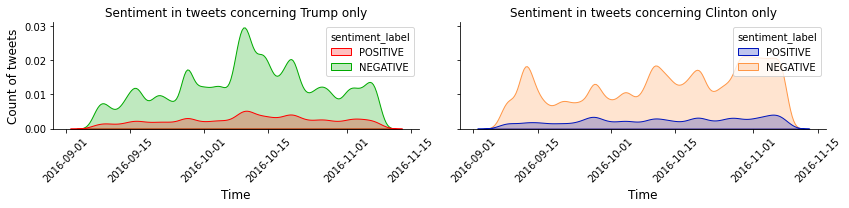

In [15]:
#kde plot
def plot_kde(ax, data, palette, title, legend=True):
    sns.kdeplot(
        data=data, 
        x="time", 
        hue="sentiment_label",
        hue_order=["POSITIVE", "NEGATIVE"],
        palette=palette,
        ax=ax,
        #multiple="stack",
        fill=True,
        legend=legend,
    )
    ax.set_title(title)
    #hide the right border and the top border so that it looks like a coordinate system
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("Time", fontsize=12,)
    ax.set_ylabel("Count of tweets", fontsize=12)

fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

plot_kde(
    axes[1], 
    dfClinton, 
    [demblue, demorange],
    "Sentiment in tweets concerning Clinton only",
)

plot_kde(
    axes[0], 
    dfTrump, 
    [repred, repgreen],
    "Sentiment in tweets concerning Trump only",
)

fig.tight_layout()

In [17]:
#histogram
def plot_histogram(ax, data, palette, title, legend=True, hue="sentiment_label", hue_order=["POSITIVE", "NEGATIVE"]):
    sns.histplot(
        data=data, 
        x="time", 
        hue=hue,
        hue_order=hue_order,
        palette=palette,
        ax=ax,
        shrink=.6,
        edgecolor=None,
        multiple="stack",
        fill=True,
        legend=legend,
    )
    ax.set_title(title)
    #hide the right border and the top border so that it looks like a coordinate system
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='x', rotation=45,)
    ax.set_xlabel("Time", fontsize=12,)
    ax.set_ylabel("Count of tweets", fontsize=12)

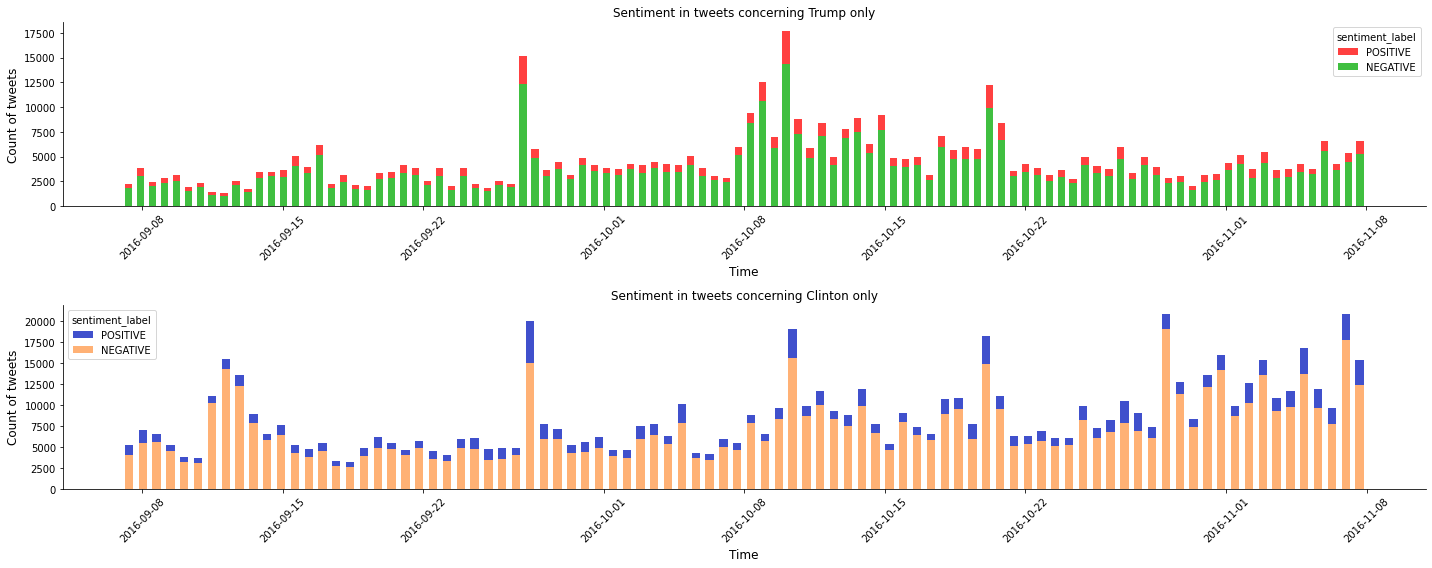

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8))

plot_histogram(
    axes[1], 
    dfClinton, 
    [demblue, demorange],
    "Sentiment in tweets concerning Clinton only",
)

plot_histogram(
    axes[0], 
    dfTrump, 
    [repred,repgreen],
    "Sentiment in tweets concerning Trump only",
)

fig.tight_layout()

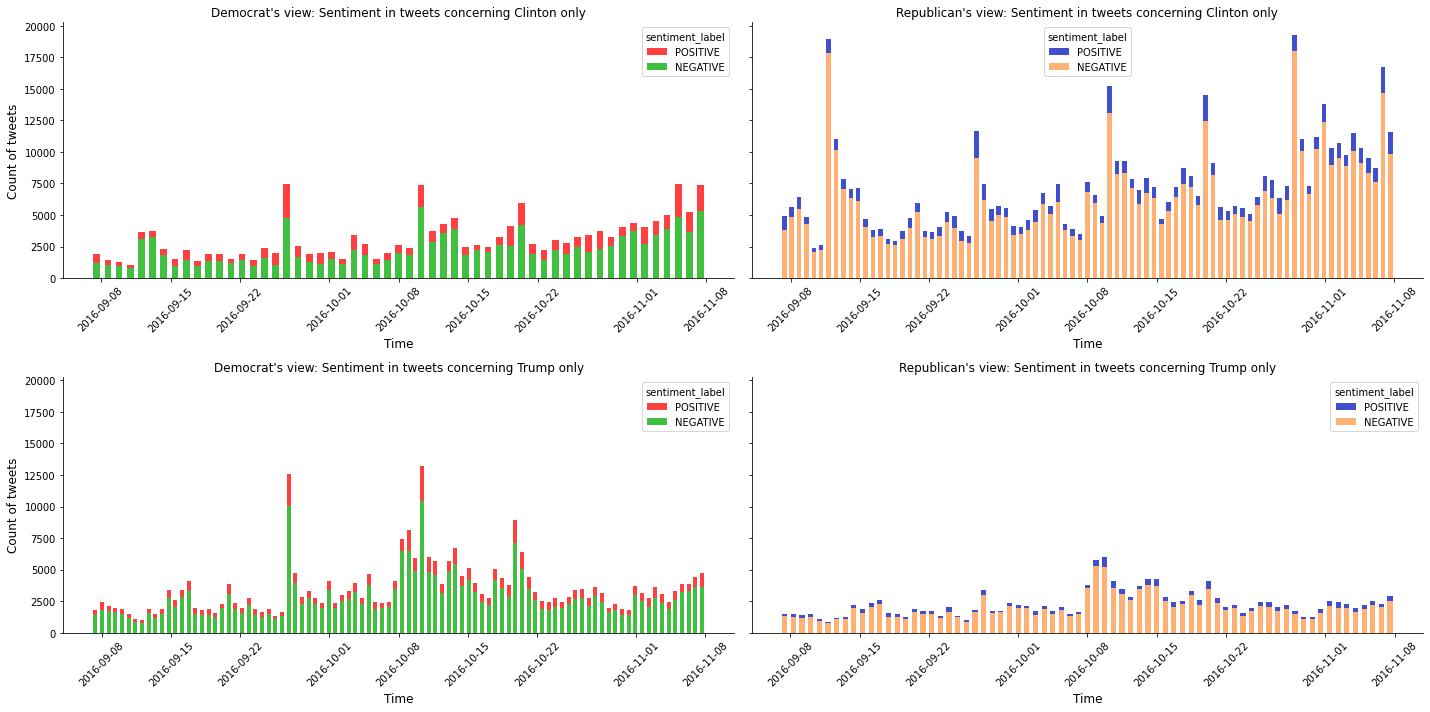

In [20]:
#histogram + political orientation
fig, axes = plt.subplots(2, 2, figsize=(20, 10),sharey=True)
plot_histogram(
    axes[0][0], 
    dfClinton[dfClinton["political_label"] == "Democrat"], 
    [repred,repgreen],
    "Democrat's view: Sentiment in tweets concerning Clinton only",
)

plot_histogram(
    axes[0][1], 
    dfClinton[dfClinton["political_label"] == "Republican"], 
    [demblue, demorange],
    "Republican's view: Sentiment in tweets concerning Clinton only",
    #legend=True
)

plot_histogram(
    axes[1][0], 
    dfTrump[dfTrump["political_label"] == "Democrat"], 
    [repred,repgreen],
    "Democrat's view: Sentiment in tweets concerning Trump only",
    legend=True
)

plot_histogram(
    axes[1][1], 
    dfTrump[dfTrump["political_label"] == "Republican"], 
    [demblue, demorange],
    "Republican's view: Sentiment in tweets concerning Trump only",
    legend=True
)


fig.tight_layout()

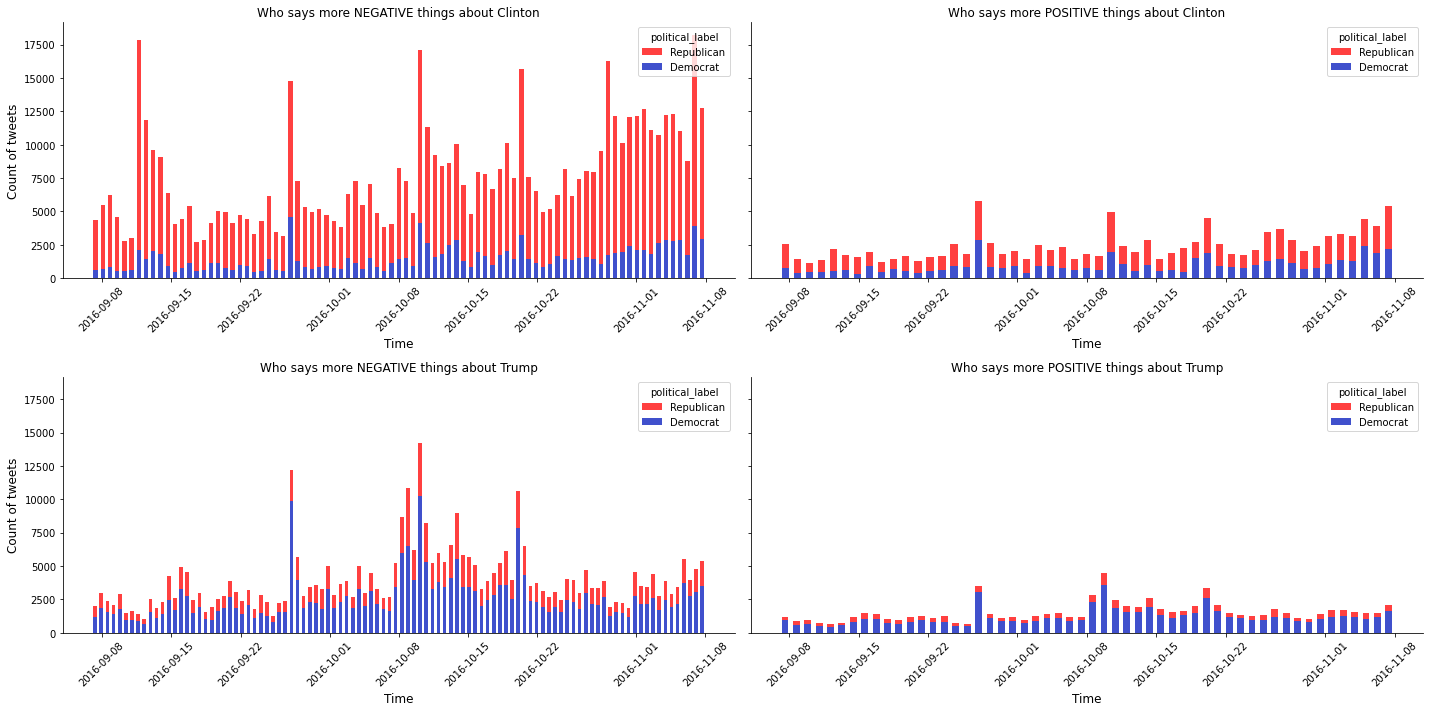

In [21]:
#histogram who dislike more clinton?
fig, axes = plt.subplots(2, 2, figsize=(20, 10),sharey=True)
plot_histogram(
    axes[0][0], 
    dfClinton[dfClinton["sentiment_label"] == "NEGATIVE"], 
    [repred,demblue],
    "Who says more NEGATIVE things about Clinton",
    hue="political_label",
    hue_order=["Republican", "Democrat"]
)

plot_histogram(
    axes[0][1], 
    dfClinton[dfClinton["sentiment_label"] == "POSITIVE"], 
    [repred,demblue],
    "Who says more POSITIVE things about Clinton",
    hue="political_label",
    hue_order=["Republican", "Democrat"]
    #legend=True
)

plot_histogram(
    axes[1][0], 
    dfTrump[dfTrump["sentiment_label"] == "NEGATIVE"], 
    [repred,demblue],
    "Who says more NEGATIVE things about Trump",
    legend=True,
    hue="political_label",
    hue_order=["Republican", "Democrat"]
)

plot_histogram(
    axes[1][1], 
    dfTrump[dfTrump["sentiment_label"] == "POSITIVE"], 
    [repred,demblue],
    "Who says more POSITIVE things about Trump",
    legend=True,
    hue="political_label",
    hue_order=["Republican", "Democrat"]
)


fig.tight_layout()


### merged from Federico

In [ ]:
dfTrump = pd.read_csv('/content/drive/MyDrive/trump_twts_2016_classified_senti+poli.csv', parse_dates=['time'])
dfClinton = pd.read_csv('/content/drive/MyDrive/clinton_twts_2016_classified_senti+poli.csv',  parse_dates=['time'])

In [ ]:
# Convert sentiment to int format
dfClinton['sentiment_label'] = dfClinton['sentiment_label'].replace({'POSITIVE': 1, 'NEGATIVE': -1})
dfTrump['sentiment_label'] = dfTrump['sentiment_label'].replace({'POSITIVE': 1, 'NEGATIVE': -1})

In [ ]:
#Average of sentiment values for each day
dfClintonDay = dfClinton.groupby([dfClinton['time'].dt.date]).mean()
dfTrumpDay = dfTrump.groupby([dfTrump['time'].dt.date]).mean()

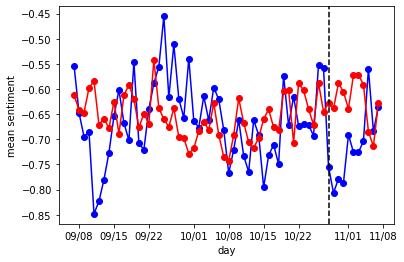

In [ ]:
plt.plot(dfClintonDay.sentiment_label,'bo-')
plt.plot(dfTrumpDay.sentiment_label,'ro-')
plt.axvline(pd.Timestamp('2016-10-28'),color='k',linestyle='--')
plt.xlabel("day")
plt.ylabel("mean sentiment")
myFmt = mdates.DateFormatter('%m/%d')
plt.gca().xaxis.set_major_formatter(myFmt)

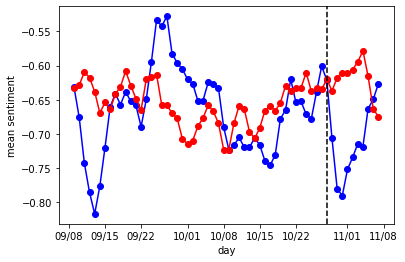

In [ ]:
window_size = 3
plt.plot(dfClintonDay.sentiment_label.rolling(window_size).mean(),'bo-')
plt.plot(dfTrumpDay.sentiment_label.rolling(window_size).mean(),'ro-')
plt.axvline(pd.Timestamp('2016-10-28'),color='k',linestyle='--')
plt.xlabel("day")
plt.ylabel("mean sentiment")
myFmt = mdates.DateFormatter('%m/%d')
plt.gca().xaxis.set_major_formatter(myFmt)

([<matplotlib.axis.XTick at 0x7fb16529b890>,
 [Text(0, 0, 'outgroup'), Text(0, 0, 'ingroup')])

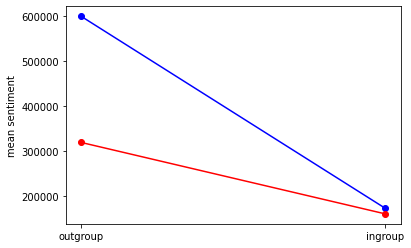

In [ ]:
# Convert Orientation to int format
dfClinton['political_label'] = dfClinton['political_label'].replace({'Democrat': -1, 'Republican': 1})
dfTrump['political_label'] = dfTrump['political_label'].replace({'Democrat': -1, 'Republican': 1})

dfClintonDayDemRep = dfClinton.groupby([dfClinton['political_label']==-1]).mean()
dfTrumpDayDemRep = dfTrump.groupby([dfTrump['political_label']==1]).mean()
plt.plot(dfClintonDayDemRep.sentiment_label,'bo-')
plt.plot(dfTrumpDayDemRep.sentiment_label,'ro-')
plt.ylabel("mean sentiment")
plt.xticks([0,1],['outgroup','ingroup'])